In [1]:
from __future__ import print_function, division

%matplotlib inline
%precision 3

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

import thinkplot

from matplotlib import rc
rc('animation', html='html5')
from Cell2D import Cell2D, Cell2DViewer


In [148]:
class Intersection(Cell2D):

    def __init__(self, numSlane=1, numNlane=1, numWlane=1, numElane=1, leftElane=0, leftSlane=0, leftNlane=0, leftWlane=0):
        self.whiteSpaceConst = 7
        m = numNlane*2 + numSlane*2  + self.whiteSpaceConst * 2 + 1 + 2 * leftNlane + 2 * leftSlane
        n = numElane * 2 + numWlane*2 + self.whiteSpaceConst * 2 + 1 + 2 * leftElane + 2 * leftWlane
        print(n,m)
        self.m = m
        self.n = n
        self.spawnLocN = []
        self.spawnLocS = []
        self.spawnLocE = []
        self.spawnLocW = []
        self.spawnLocNL = []
        self.spawnLocSL = []
        self.spawnLocEL = []
        self.spawnLocWL = []
        self.array = np.zeros((n, m), np.float)
        for i in range(self.whiteSpaceConst):
            laneConst = 0
            for j in range(numNlane):
                #Declare Spawn location of NLANE
                if i ==0:
                    self.spawnLocN.append((0,self.whiteSpaceConst+laneConst+1))
                if j is 0:
                    self.array[i, self.whiteSpaceConst + laneConst] = 1
                    self.array[n- i -1, self.whiteSpaceConst + laneConst] = 1
                    
                    
                else:
                    self.array[i, self.whiteSpaceConst + laneConst] = .2
                    self.array[n-i-1, self.whiteSpaceConst + laneConst] = .2
                laneConst = laneConst + 2


            for j in range(leftNlane):
                if i ==0:
                    self.spawnLocNL.append((0,self.whiteSpaceConst+laneConst+1))
                    self.spawnLocNL.append((n-1,self.whiteSpaceConst+laneConst+1))
                self.array[i, self.whiteSpaceConst + laneConst] = .5
                if j == 0:
                    self.array[n-i-1, self.whiteSpaceConst + laneConst ] = 1
                else:
                    self.array[n-i-1, self.whiteSpaceConst + laneConst ] = .5
                self.array[n-i-1, self.whiteSpaceConst + laneConst + 2] = .5
                laneConst = laneConst + 2

                
            for j in range(numSlane):
                if i ==0:
                    self.spawnLocS.append((self.n - 1, self.whiteSpaceConst+laneConst+1))
                if j is 0:
                    if(leftNlane):
                        self.array[i, self.whiteSpaceConst + laneConst] = 1
                    else:
                        self.array[i, self.whiteSpaceConst + laneConst] = 1
                        self.array[n- i -1, self.whiteSpaceConst + laneConst] = 1
                else:
                    self.array[i, self.whiteSpaceConst + laneConst] = .2
                    self.array[n-i-1, self.whiteSpaceConst + laneConst] = .2
                laneConst = laneConst + 2
            
            self.array[i, self.whiteSpaceConst + laneConst] = 1
            self.array[n-i-1, self.whiteSpaceConst + laneConst] = 1
            laneConst = 0
            for j in range(numElane):
                if i ==0:
                    self.spawnLocE.append((self.whiteSpaceConst+laneConst+1, self.m - 1))
                if j is 0:
                    self.array[self.whiteSpaceConst + laneConst, i] = 1
                    self.array[ self.whiteSpaceConst + laneConst, m- i -1] = 1
                else:
                    self.array[self.whiteSpaceConst + laneConst, i ] = .2
                    self.array[ self.whiteSpaceConst + laneConst, m-i-1] = .2
                laneConst = laneConst + 2
                
            for j in range(leftWlane):
                if i ==0:
                    self.spawnLocE.append((self.whiteSpaceConst+laneConst+1, self.m - 1))
                    self.spawnLocE.append((self.whiteSpaceConst+laneConst+1, 0))
                self.array[self.whiteSpaceConst + laneConst + 2, i] = .5
                if j == 0:
                    self.array[self.whiteSpaceConst + laneConst, i] = 1
                else:
                    self.array[ self.whiteSpaceConst + laneConst, m-i-1] = .5
                self.array[ self.whiteSpaceConst + laneConst, m-i-1] = .5
                self.array[ self.whiteSpaceConst + laneConst + 2, i] = .5
                laneConst = laneConst + 2
            
            for j in range(numWlane):
                if i ==0:
                    self.spawnLocE.append((self.whiteSpaceConst+laneConst+1, 0))
                if j is 0:
                    if(leftWlane):
                        self.array[self.whiteSpaceConst + laneConst, i] = 0.5
                        self.array[ self.whiteSpaceConst + laneConst, m- i -1] = 1

                    else:
                        self.array[self.whiteSpaceConst + laneConst, i] = 1
                        self.array[ self.whiteSpaceConst + laneConst, m- i -1] = 1
                    
                else:
                    self.array[self.whiteSpaceConst + laneConst, i] = .2
                    self.array[self.whiteSpaceConst + laneConst, m- i -1] = .2
                laneConst = laneConst + 2
            
            self.array[self.whiteSpaceConst + laneConst, i] = 1
            self.array[self.whiteSpaceConst + laneConst, m- i -1] = 1
        
       

            
        print(self.array)
    def step(self):
        for item in self.spawnLocN:
            self.populateLane(item[0], item[1],.30, "N")
        for item in self.spawnLocS:
            self.populateLane(item[0], item[1],.30, "S")
        for item in self.spawnLocE:
            self.populateLane(item[0], item[1],.30, "E")
        for item in self.spawnLocW:
            self.populateLane(item[0], item[1],.30, "W")
        for item in self.spawnLocNL:
            self.populateLane(item[0], item[1],.30, "NL")
        for item in self.spawnLocWL:
            self.populateLane(item[0], item[1],.30, "WL")
        for item in self.spawnLocEL:
            self.populateLane(item[0], item[1],.30, "EL")
        for item in self.spawnLocSL:
            self.populateLane(item[0], item[1],.30, "SL")
        
    def populateLane(self, y, x, probability=0, direction="N"):
        if direction == "N":
            if (probability > np.random.random()):
                self.array[y, x] = 0.7
        if direction == "E":
            if (probability > np.random.random()):
                self.array[y, x] = 0.7
        if direction == "S":
            if (probability > np.random.random()):
                self.array[y, x] = 0.7
        if direction == "W":
            if (probability > np.random.random()):
                self.array[y, x] = 0.7
        if direction == "NL":
            if (probability > np.random.random()):
                self.array[y, x] = 0.7
        if direction == "SL":
            if (probability > np.random.random()):
                self.array[y, x] = 0.7
        if direction == "EL":
            if (probability > np.random.random()):
                self.array[y, x] = 0.7
        if direction == "WL":
            if (probability > np.random.random()):
                self.array[y, x] = 0.7

In [149]:
class IntersectionView(Cell2DViewer):
    cmap = plt.get_cmap('spectral_r')
intersection = Intersection(numNlane=4, numSlane=5, numElane=2, numWlane=2, leftNlane=1, leftWlane=1)
viewer = IntersectionView(intersection)

25 35
[[0.  0.  0.  0.  0.  0.  0.  1.  0.  0.2 0.  0.2 0.  0.2 0.  0.5 0.  1.
  0.  0.2 0.  0.2 0.  0.2 0.  0.2 0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  1.  0.  0.2 0.  0.2 0.  0.2 0.  0.5 0.  1.
  0.  0.2 0.  0.2 0.  0.2 0.  0.2 0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  1.  0.  0.2 0.  0.2 0.  0.2 0.  0.5 0.  1.
  0.  0.2 0.  0.2 0.  0.2 0.  0.2 0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  1.  0.  0.2 0.  0.2 0.  0.2 0.  0.5 0.  1.
  0.  0.2 0.  0.2 0.  0.2 0.  0.2 0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  1.  0.  0.2 0.  0.2 0.  0.2 0.  0.5 0.  1.
  0.  0.2 0.  0.2 0.  0.2 0.  0.2 0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  1.  0.  0.2 0.  0.2 0.  0.2 0.  0.5 0.  1.
  0.  0.2 0.  0.2 0.  0.2 0.  0.2 0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  1.  0.  0.2 0.  0.2 0.  0.2 0.  0.5 0.  1.
  0.  0.2 0.  0.2 0.  0.2 0.  0.2 0.  1.  0.  0.  0.  0. 

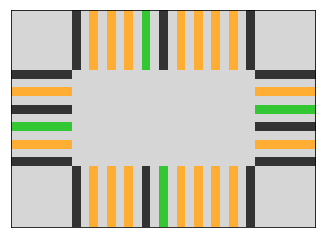

In [150]:
anim = viewer.animate()

In [151]:
anim